In [1]:
import mne # package for reading edf data
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from sklearn.decomposition import PCA
from data_tools import * # i made all t # i made all the functions into a python file
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
band = [4,8,12,30,45] #4 bands
window_size = 2000 #Averaging band power of 2 sec
step_size = 125 #1/8 second step
sample_rate = 1000 #Each 0.125 sec update once

In [3]:
bandNames = ['theta', 'alpha', 'beta', 'gamma']
colNames = ['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3',
       'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
finalHeaderNames = []
for header in colNames:
    for bandName in bandNames:
        finalHeaderNames.append(bandName + '_' + header)

In [32]:
def FFT_Processing (clip):
    meta = pd.DataFrame(data=[], columns=finalHeaderNames)
    start = 0
    while start + window_size < clip.shape[0]:
        metaClip = pd.DataFrame(data=[], columns=finalHeaderNames)
        meta_array = []
        meta_data = [] #meta vector for analysis
        for (columnName, columnData) in clip.iteritems():
            X = columnData[start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
            Y = quick_bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
            meta_data.append(list(Y[0]))
        metaClip = pd.DataFrame(data=[np.array(meta_data).flatten()], columns=finalHeaderNames)
        meta = meta.append(metaClip)
        start = start + step_size
    return meta.reset_index(drop=True)

In [27]:
# Create empty lists to store our data
train_data = []
train_labels = []
test_data = []
test_labels = []
train_pca = []
test_pca = []

test_set = np.random.choice(124, size=24, replace=False)

# Going through all 124 trials
for subject in range(1,32):
    for trial in range(2,6):
        df = get_recording_events(subject, trial)
        labels = df.groupby('song_clip').head(1).TARGET.to_list() # Should be an array of 10 labels for each of the songs played in this trial
        recordings = [df[df.song_clip==x].drop(columns=['song_clip','Number','TARGET','time']) for x in df.song_clip.unique()] 
        # Going through all 10 playings
        for playing in range(0,10):
            recording = recordings[playing]
            if recording.shape[0] < 16000:
                continue
            recording = recording.iloc[:16000,:]

            # FFT
            fft_recording = FFT_Processing(recording)

            # PCA
            pca = PCA(n_components=2)
            pca_clip = pca.fit(fft_recording, train_labels).transform(fft_recording).T[0]

           
            if subject == 31:
                test_data.append(recording)
                test_labels.append(labels[playing])
                test_pca.append(pca_clip)
            else:
                train_data.append(recording)
                train_labels.append(labels[playing])
                train_pca.append(pca_clip)
                    
print('Processing completed!')

Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-28\eeg\sub-28_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:16: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(fileName)
Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-28\eeg\sub-28_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:16: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(fileName)
Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-28\eeg\sub-28_task-run4_eeg.edf...
EDF file detected
Setting channel info structure...


In [28]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(train_pca, train_labels).transform(train_pca)

ValueError: Found array with dim 3. LinearDiscriminantAnalysis expected <= 2.

In [22]:
X_r2.shape

(119, 2)

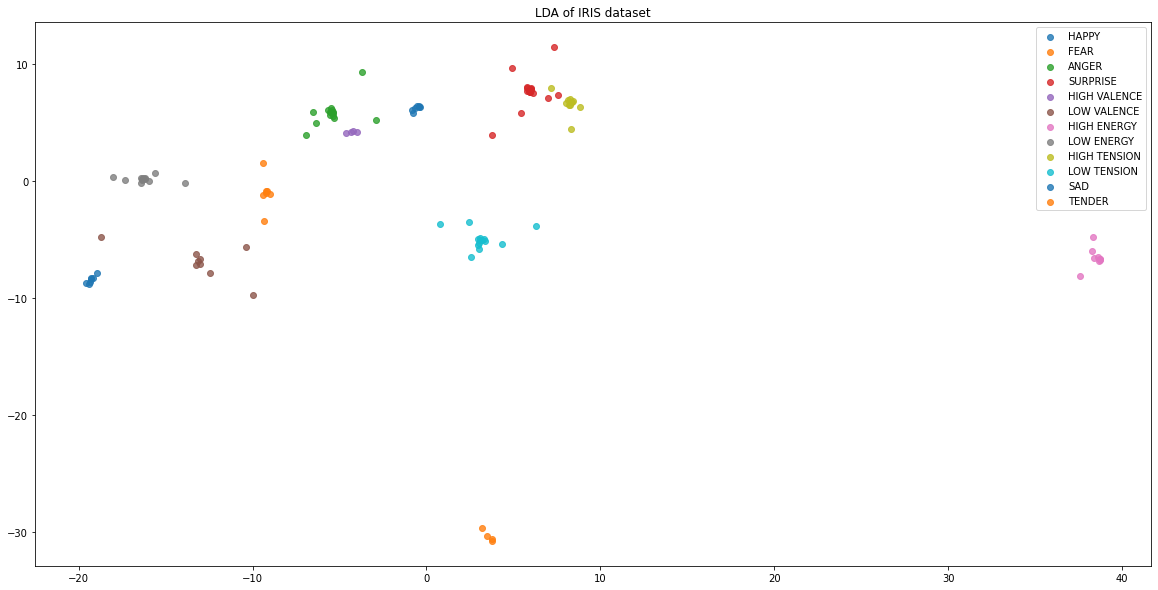

In [24]:
plt.figure(figsize=(20,10))
target_names = ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'LOW VALENCE', 'HIGH ENERGY', 'LOW ENERGY', 'HIGH TENSION', 'LOW TENSION', 'SAD', 'TENDER']

for target_name in target_names:
    plt.scatter(X_r2[[index for index, value in enumerate(train_labels) if value == target_name], 0], X_r2[[index for index, value in enumerate(train_labels) if value == target_name], 1], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

In [25]:
lda100 = LinearDiscriminantAnalysis(n_components=11)
X_r100 = lda100.fit(train_pca, train_labels)
predictions = pd.DataFrame({'prediction': lda100.predict(test_pca), 'label': test_labels})
predictions




,prediction,label
0,HAPPY,TENDER
1,ANGER,SURPRISE
2,LOW ENERGY,SURPRISE
3,LOW ENERGY,LOW TENSION
4,HIGH ENERGY,ANGER
5,HIGH ENERGY,FEAR
6,LOW VALENCE,ANGER
7,LOW VALENCE,LOW TENSION
8,HIGH ENERGY,SURPRISE
9,HIGH ENERGY,HAPPY


In [26]:
predictions['correct'] = predictions['prediction'] == predictions['label']
predictions

,prediction,label,correct
0,HAPPY,TENDER,False
1,ANGER,SURPRISE,False
2,LOW ENERGY,SURPRISE,False
3,LOW ENERGY,LOW TENSION,False
4,HIGH ENERGY,ANGER,False
5,HIGH ENERGY,FEAR,False
6,LOW VALENCE,ANGER,False
7,LOW VALENCE,LOW TENSION,False
8,HIGH ENERGY,SURPRISE,False
9,HIGH ENERGY,HAPPY,False


In [11]:
print(test_pca)

89.25793895,   -618.14458216,
        -1802.08629505,   1210.60624559,  -3750.73940904,  -2278.46680586,
        -9840.58859144, -10672.44438338, -15207.13289524, -18551.16897356,
       -18576.6324114 , -19894.2072655 , -16406.12560375,  -9813.06556202,
        -9853.49867294, -10998.65365408,  -7806.86455228,  -8807.19902382,
        -8315.8122856 ,  -7102.93175216,   -744.68525557,   1089.05968915,
         7408.19016942,   8874.11308538,  13739.51518242,  15443.69504566,
        14640.29498363,  13695.36604305,  12575.82341832,   5900.63164395,
         8488.85417466,  10179.55762099,   8465.15128548,  10513.27561348,
         6165.29537512,   2129.29826946,   -247.42528361,   1556.75464599,
        -1324.68490308,  -1167.46895247,  -5882.43310061, -10666.40101962,
       -10216.03287779, -11637.65251927, -10964.55497088, -15556.69928941,
       -11228.50441916, -15375.14021622, -15939.74638724, -16436.19808524,
       -19000.3169227 , -22573.20872516, -24671.77319909, -28195.27772

In [15]:
predictions = pd.DataFrame({'prediction': lda.predict(test_pca), 'label': test_labels})

In [16]:
predictions['correct'] = predictions['prediction'] == predictions['label']
predictions

,prediction,label,correct
0,HAPPY,TENDER,False
1,ANGER,SURPRISE,False
2,LOW ENERGY,SURPRISE,False
3,LOW ENERGY,LOW TENSION,False
4,HIGH ENERGY,ANGER,False
5,HIGH ENERGY,FEAR,False
6,LOW VALENCE,ANGER,False
7,LOW VALENCE,LOW TENSION,False
8,HIGH ENERGY,SURPRISE,False
9,HIGH ENERGY,HAPPY,False


In [13]:
print(test_labels)

['TENDER', 'SURPRISE', 'SURPRISE', 'LOW TENSION', 'ANGER', 'FEAR', 'ANGER', 'LOW TENSION', 'SURPRISE', 'HAPPY', 'SURPRISE', 'ANGER', 'LOW ENERGY', 'HIGH TENSION', 'ANGER', 'SURPRISE', 'HAPPY', 'SAD', 'HIGH VALENCE', 'LOW VALENCE', 'LOW ENERGY', 'LOW ENERGY', 'LOW TENSION', 'HIGH TENSION', 'HIGH VALENCE', 'HIGH TENSION', 'HIGH VALENCE', 'LOW ENERGY', 'HIGH ENERGY', 'HIGH ENERGY', 'HIGH ENERGY', 'HIGH ENERGY', 'HAPPY', 'LOW VALENCE', 'SURPRISE', 'LOW TENSION', 'TENDER', 'LOW ENERGY']


In [9]:
output = [lda.predict(test) for test in test_pca]
print(output)

ValueError: Expected 2D array, got 1D array instead:
array=[ -9096.11014383 -13834.4766661  -11464.39462907 -14122.869196
 -13295.05578388 -13200.99249399 -24435.5996081  -15071.40389288
 -20271.21412239 -18624.32254758 -19950.73309618 -14073.0619853
 -17591.45966508 -12635.32331797 -18912.33847054 -15128.64749886
 -11572.06410814 -10696.43986866 -16337.29977285 -21025.5033695
 -18464.40869802 -16670.4438422  -17415.81054551 -22432.79320939
 -21737.07395599 -21189.70001868 -25730.55324256 -26694.08690477
 -20315.53851809  -8957.83557598 -18896.65622316 -13977.80867132
 -16636.1881002  -11010.2741852  -15276.46930391  -8404.88821117
 -12146.32682962 -14351.08289647 -14422.00268194 -10421.59585512
 -12938.76543666 -13332.70977998 -11172.91116171  44086.34065423
  50238.66162822  43111.63893464  41465.53550933  42188.61610342
  44563.12502598  44720.39689767  43481.11598319  45239.83176013
  44618.90095285  46299.31235431  44894.33766178  46600.18073419
  43498.95295692  48145.59286823  40899.95438343  79234.77933436
   5507.62653185  -9837.18208643 -13721.56377795 -13452.7432711
 -18349.27935192 -19047.03254538 -18813.60165647 -16083.06267704
 -16612.632658   -15694.17615297 -14834.12918514 -15050.90614021
 -14671.27329837 -16016.54726376  40282.2178711   17462.50325434
  17242.74596524  17445.9697373   18277.8111229   18471.89432635
  18841.31080529  19918.00395383  19982.96067755  22803.10252655
  23641.63232647  23699.60996584  27020.37879633  26477.47639895
  29624.85143767  21418.80338032  11195.11720641  -7422.69311699
 -12321.67975483  -8939.5485368   -8210.78606852 -11295.29291854
 -13345.99426694 -12252.29409188 -10536.15667672 -15563.16303962
 -11662.99590443 -15645.54161528 -17923.26834686 -16892.15799757
 -18604.61384286 -16815.81240033 -16202.42632031 -19225.58971046
 -15180.76427714 -12206.07816018 -13613.3174655  -12621.75136617].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [3]:
def binarizer(x):
    """divides the feature space by perceived arousal level of emotion (high/low)"""
    if x in ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'HIGH ENERGY','HIGH TENSION']:
        return 1
    return 0

In [4]:
band = [4,8,12,30,45] #4 bands
window_size = 2000 #Averaging band power of 2 sec
step_size = 125 #1/8 second step
sample_rate = 1000 #Each 0.125 sec update once

In [13]:
print(len(finalHeaderNames))

92


In [8]:
print(train_data[0])

              FP1        FP2         F7         F3         Fz         F4  \
0     -232.628543 -84.023245  57.974299  -3.002626   8.304956 -12.351710   
1     -232.815737 -84.354865  58.570296  -2.830203   9.961316 -13.989259   
2     -233.876498 -83.967975  59.357012  -1.623242  11.123769 -12.522584   
3     -238.306737 -87.947411  57.235262  -2.334487   7.928387 -14.345248   
4     -241.738612 -89.329159  53.254002  -4.317351   9.344615 -11.981481   
...           ...        ...        ...        ...        ...        ...   
15995  -62.781916  39.394522  75.735013  10.489473   4.733005  13.464603   
15996  -67.524143  35.857246  72.492789  11.761092   3.136678  11.656180   
15997  -61.908347  33.646449  77.642204  14.541413   3.133949  10.303422   
15998  -59.974018  35.249277  75.210535  13.291346   3.338606  11.627701   
15999  -61.284370  34.862387  70.347199  11.071400   2.580010   9.463289   

              F8         T3         C3         Cz         C4          T4  \
0      -4.5

In [16]:
print(len(train_data))
fft_data = []
print
count = 0
for trainingDF in train_data:
    fft_data.append(FFT_Processing(trainingDF))
    count = count + 1
    print("Done with ", count)

1171
Done with  1
Done with  2
Done with  3
Done with  4
Done with  5
Done with  6
Done with  7
Done with  8
Done with  9
Done with  10
Done with  11
Done with  12
Done with  13
Done with  14
Done with  15
Done with  16
Done with  17
Done with  18
Done with  19
Done with  20
Done with  21
Done with  22
Done with  23
Done with  24
Done with  25
Done with  26
Done with  27
Done with  28
Done with  29
Done with  30
Done with  31
Done with  32
Done with  33
Done with  34
Done with  35
Done with  36
Done with  37
Done with  38
Done with  39
Done with  40
Done with  41
Done with  42
Done with  43
Done with  44
Done with  45
Done with  46
Done with  47
Done with  48
Done with  49
Done with  50
Done with  51
Done with  52
Done with  53
Done with  54
Done with  55
Done with  56
Done with  57
Done with  58
Done with  59
Done with  60
Done with  61
Done with  62
Done with  63
Done with  64
Done with  65
Done with  66
Done with  67
Done with  68
Done with  69
Done with  70
Done with  71
Done with 

In [58]:
pca = PCA(n_components=1)
fft_np = np.array(fft_data[0])
apca = pca.fit(fft_np, train_labels).transform(fft_np)

In [60]:
print(len(test_labels))
apca.shape

38


(112, 1)

ValueError: Found input variables with inconsistent numbers of samples: [112, 1171]

apply a fourier transform to the data in discrete sections so that you can get the average levels of each 

In [32]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(fft_resize, train_labels).transform(fft_resize)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(apca[y == i, 0], apca[train_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [77, 1171]

In [ ]:
# Seperate target and non-target for plotting
tar     = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 1)[0], :, :]
non_tar = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 0)[0], :, :]

print('We have %d target trials' % tar.shape[0])
print('We have %d non-target trials' % non_tar.shape[0])

# We'll take the average of all trials to create an averaged ERP
tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

# Define channel of interest and create an array of time points
chan = 'Cz' # let's plot Cz
ch = np.where(channels == chan)[0][0]
times = np.linspace(epoch_start, epoch_end, train_data.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

# Plot x and y axes
plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc="upper right");
plt.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
plt.show();

In [ ]:
# Let's compute the windowed means within erp_start and erp_end
num_points = 5; # we will divide our window into num_points means

# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

# Combine into a single train variable. Also create labels
X_train    = wm(train_data, erp_s, erp_e, num_points)
markers_train = np.vstack((train_labels, train_markers)).T
y = train_labels

# Now let's compute windowed means of our test data
X_test = wm(test_data, erp_s, erp_e, num_points)
markers_test = test_markers

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

In [ ]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
X_train = X_train.reshape(-1, X_train.shape[-1]).T
X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

In [ ]:
# Train our classifier (this may take a while via JupyterHub)
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(X_train, y)

In [ ]:
# Let's do 5-fold cross validation
score_lsqrs = cross_val_score(clf_lsqrs.fit(X_train, y), X_train, y, cv = 5)

# We will print out the mean score
print("solver = lsqr  accuracy: %f" % np.mean(score_lsqrs))

# Prototyping

In [11]:
df = get_recording_events(2, 3)
df = df[df.song_clip==29].drop(columns=['song_clip','Number','TARGET','time'])

Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-02\eeg\sub-02_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:16: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(fileName)


In [12]:
array = FFT_Processing(df)

ValueError: 92 columns passed, passed data had 76 columns

In [3]:
df = get_recording_events(2, 3)
print(df.columns)

Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-02\eeg\sub-02_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:16: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(fileName)
Index(['time', 'song_clip', 'FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3',
       'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2',
       'Number', 'TARGET'],
      dtype='object')
